# Affirmation Journal

- We created a journal that allows users to categorize and log affirmations
- We wanted to test the power of using AI to accelerate the SDLC and quickly produce a tool that could be useful to customers
 

In [88]:
import sys
import os
import json

# Add the project's root directory to the Python path to ensure 'utils' can be imported.
try:
    # Assumes the notebook is in 'labs/Day_01_.../'
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
except IndexError:
    # Fallback for different execution environments
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_completion, get_vision_completion, save_artifact, load_artifact, clean_llm_output, render_mermaid_diagram

# Initialize the LLM client. You can change the model here.
# For example: setup_llm_client(model_name="gemini-2.5-flash")p
client, model_name, api_provider = setup_llm_client(model_name="gpt-4o")

✅ LLM Client configured: Using 'openai' with model 'gpt-4o'


# Phase 1 - Brainstorm Requirements

-   Brainstorm features and user personas.
- Create user stories.
- Generate a PRD from the user stories.
- Create a README using the PRD and user stories.

In [26]:
problem_statement = "We need to create a tool to log daily affirmations. This tool is intended to take user input each day and log their affirmation messages. It should be simple to use, allow users to review past affirmations, and provide a positive user experience."
# This prompt should ask the LLM to brainstorm features based on the problem_statement.
features_prompt = """ # Create a list of features for an affirmation logging tool. This tool is intended to take user input each day and log their affirmation messages. Output should be the list ONLY. And Concise. """

print("--- Brainstorming Features ---")
brainstormed_features = get_completion(features_prompt, client, model_name, api_provider)
print(brainstormed_features)

# TODO: Create a string variable named 'personas_prompt'.
# This prompt should ask the LLM to identify three user personas based on the problem_statement.
personas_prompt = """ # Identify three user personas for an affirmation logging tool. This tool is intended to take user input each day and log their affirmation messages. Output should be a list of personas with a brief description of each. Output list items ONLY, and be concise. """

print("\n--- Identifying User Personas ---")
user_personas = get_completion(personas_prompt, client, model_name, api_provider)
print(user_personas)

# This prompt needs to instruct the LLM to act as a Senior Product Manager and convert the
# brainstormed features and personas into a structured JSON array of user stories.
# Tip: Be very specific about the required JSON format in your prompt instructions. Tell it what keys to use and what the data types should be.
json_user_stories_prompt = f"""  
- Act as a Senior Product Manager.  
- Use the following features and personas as context:  
-- Features: {brainstormed_features}  
-- Personas: {user_personas}
- Generate a list of formal Agile user stories, each with detailed acceptance criteria in Gherkin (Given/When/Then).  
- Output a well-formed JSON array of objects only—no text before or after.  
- Each object must include: id, user_story, persona, acceptance_criteria.  
- Output must be plain JSON, not markdown.  
- Your response must start with [ and end with ].  
"""


print("--- Generating User Stories as JSON ---")
json_output_str = get_completion(json_user_stories_prompt, client, model_name, api_provider, temperature=0.2)

# Let's try to parse the JSON to see if the LLM followed instructions
try:
    # The LLM might wrap the JSON in markdown fences (```json ... ```).
    # We'll clean that up before parsing.
    if '```' in json_output_str:
        json_output_str = json_output_str.split('```')[1].lstrip('json').strip()
    
    user_stories_json = json.loads(json_output_str)
    print("Successfully parsed LLM output as JSON.")
    
    if user_stories_json:
        print("\n--- Sample User Story ---")
        print(json.dumps(user_stories_json[0], indent=2))
    else:
        print("JSON array is empty.")

except (json.JSONDecodeError, TypeError, IndexError) as e:
    print(f"Error: Failed to parse LLM output as JSON. Error: {e}")
    print("LLM Output was:\n", json_output_str)
    user_stories_json = []

def validate_and_save_stories(stories_data):
    """Validates the structure of the user stories data and saves it if valid."""
    if not isinstance(stories_data, list) or not stories_data:
        print("Validation Failed: Data is not a non-empty list.")
        return

    required_keys = ['id', 'persona', 'user_story', 'acceptance_criteria']
    all_stories_valid = True

    # 1. Loop through each story in the 'stories_data' list.
    # 2. For each story, check if it contains all the 'required_keys'.
    # 3. Also check if the 'acceptance_criteria' list is not empty.
    # 4. If a story is invalid, print an error message and set 'all_stories_valid' to False.
    #    (You can use 'continue' to skip to the next story).

    # Your validation code here
    for i, story in enumerate(stories_data):
        if not all(key in story for key in required_keys):
            print(f"Validation Error: Story {i} missing required keys.")
            all_stories_valid = False
            continue
        ac = story['acceptance_criteria']
        if (isinstance(ac, str) and not ac.strip()) or (isinstance(ac, list) and not ac):
            print(f"Validation Error: Story {i} has empty acceptance_criteria.")
            all_stories_valid = False
            continue
        if not isinstance(ac, (str, list)):
            print(f"Validation Error: Story {i} acceptance_criteria is neither string nor list.")
            all_stories_valid = False
            continue



    if all_stories_valid:
        print("\nAll user stories passed validation.")
        artifact_path = "Capstone\\capstone_artifacts\\user_stories.json"
        
        # TODO: Call the save_artifact function from utils.py to save the data.
        # Remember to convert the Python list back to a JSON string using json.dumps().
        save_artifact(json.dumps(stories_data, indent=2), artifact_path)
        print(f"User stories saved to {artifact_path}.")
        
    else:
        print("\nValidation failed. Artifact not saved.")

# Run the validation on the JSON data from the previous step
if 'user_stories_json' in locals() and user_stories_json:
    validate_and_save_stories(user_stories_json)
else:
    print("Skipping validation as user_stories_json is empty or not defined.")

--- Brainstorming Features ---
- Daily affirmation entry  
- Date and time stamp  
- Mood tracking  
- Affirmation category tags  
- Voice-to-text input  
- Affirmation history view  
- Search and filter functions  
- Reminder notifications  
- Progress tracking  
- Privacy and security settings

--- Identifying User Personas ---
1. **Mindful Professional**: A busy working individual seeking to incorporate positivity into their routine to improve focus and productivity at work.

2. **Personal Growth Enthusiast**: A self-improvement seeker who regularly engages in activities like journaling and meditation to enhance emotional well-being and personal development.

3. **Mental Health Advocate**: Someone managing mental health challenges who uses affirmations as a therapeutic tool to boost self-esteem and foster a positive mindset.
--- Generating User Stories as JSON ---
Successfully parsed LLM output as JSON.

--- Sample User Story ---
{
  "id": 1,
  "user_story": "As a Mindful Profession

In [27]:
user_stories_str = load_artifact("Capstone/capstone_artifacts/user_stories.json")
if user_stories_str:
    user_stories_data = json.loads(user_stories_str)
else:
    print("Warning: Could not load user stories. Lab may not function correctly.")
    user_stories_data = []

simple_prd_prompt = f"""
You are a Product Manager writing a Product Requirements Document (PRD) for an affirmations tool.

Use the following JSON data containing user stories as your primary source of information:
<user_stories>
{user_stories_str}
</user_stories>

Generate a PRD in markdown format with the following sections:
1. **Introduction:** A brief overview of the project's purpose.
2. **User Personas:** A summary of the key users involved.
3. **Features / User Stories:** A list of the user stories and their acceptance criteria.
"""

print("--- Generating Simple PRD ---")
if user_stories_data:
    simple_prd_output = get_completion(simple_prd_prompt, client, model_name, api_provider)
    print(simple_prd_output)
else:
    print("Skipping PRD generation because user stories are missing.")

--- Generating Simple PRD ---
# Product Requirements Document (PRD) for Affirmations Tool

## 1. Introduction

The purpose of this project is to develop a user-friendly affirmations tool designed to enhance positivity, mindfulness, and personal growth. This tool will empower users to easily record, organize, and reflect on their daily affirmations, thereby fostering a consistent routine that contributes to mental well-being and productivity. The tool is aimed at individuals who prioritize personal development, mindfulness, and mental health advocacy.

## 2. User Personas

### Mindful Professional
- **Description:** Individuals who integrate mindfulness into their daily routines to boost focus and productivity.
- **Needs:** Tools to track positivity routines and reflect on past affirmations.

### Personal Growth Enthusiast
- **Description:** Individuals passionate about self-improvement and personal development.
- **Needs:** Features to organize, retrieve, and secure personal thoughts a

In [28]:
# Load the PRD template from the 'templates' directory.
prd_template_content = load_artifact("templates/prd_template.md")

template_prd_prompt = f"""
You are a Senior Product Manager responsible for creating a detailed and formal Product Requirements Document (PRD).

Your task is to populate the provided PRD template using the information from the user stories JSON.

<prd_template>
{prd_template_content}
</prd_template>

<user_stories_json>
{user_stories_str}
</user_stories_json>

Fill out every section of the template. For sections like 'Success Metrics' or 'Out of Scope', you must infer reasonable content based on the user stories and the overall project goal of creating an affirmations tool.
The final output should be the completed PRD in markdown format.
"""

print("--- Generating PRD from Template ---")
if user_stories_data and prd_template_content:
    prd_from_template_output = get_completion(template_prd_prompt, client, model_name, api_provider)
    print(prd_from_template_output)
else:
    print("Skipping PRD generation because user stories or template are missing.")
    prd_from_template_output = ""

--- Generating PRD from Template ---
```markdown
# Product Requirements Document: Affirmation Tracker

| Status | **Draft** |
| :--- | :--- |
| **Author** | Product Management Team |
| **Version** | 1.0 |
| **Last Updated** | [Date] |

## 1. Executive Summary & Vision
The Affirmation Tracker is designed to help users cultivate a positive mindset through daily affirmations. It allows users to enter, categorize, and track their affirmations, enhancing their personal growth journey. The ultimate vision is to empower users to maintain a consistent affirmation practice, leading to improved mental well-being and productivity.

## 2. The Problem
**2.1. Problem Statement:**
Individuals who wish to maintain a positive mindset often lack a structured way to record, organize, and reflect on their daily affirmations, making it difficult to track progress and maintain consistency.

**2.2. User Personas & Scenarios:**

- **Persona 1: The Mindful Professional**
  - Scenario: Wants to track daily affi

In [29]:
pydantic_model_prompt = f"""
You are a Python developer specializing in data validation with Pydantic.

Based on the following markdown PRD template, generate a single Pydantic model class named `ProductRequirementsDocument` that represents its structure.

<prd_template>
{prd_template_content}
</prd_template>

The model should have fields that correspond to the main sections of the template. Use appropriate Python types (e.g., str, List, Dict) from the `typing` library.
Ensure you include the necessary imports from `pydantic` and `typing`.
Only output the raw Python code for the model, without any explanation.
"""

print("--- Generating Pydantic Model for PRD ---")
if prd_template_content:
    pydantic_model_code = get_completion(pydantic_model_prompt, client, model_name, api_provider)
    
    # Use our standardized cleaning function
    cleaned_code = clean_llm_output(pydantic_model_code, language='python')
    
    print("\n--- Generated Pydantic Model ---")
    print(cleaned_code)

    # Save the generated Pydantic model code to a file.
    model_path = "Capstone/validation_models/prd_model.py"
    save_artifact(cleaned_code, model_path)
else:
    print("Skipping Pydantic model generation because template is missing.")

# Finally, save the completed PRD from the intermediate challenge as our official artifact
if prd_from_template_output:
    save_artifact(prd_from_template_output, "Capstone/capstone_artifacts/capstone_prd.md")

--- Generating Pydantic Model for PRD ---

--- Generated Pydantic Model ---
from pydantic import BaseModel
from typing import List, Dict, Optional

class Goal(BaseModel):
    goal: str
    kpi: str
    target: str

class Persona(BaseModel):
    name: str
    scenario: str

class UserStory(BaseModel):
    story_id: str
    description: str
    acceptance_criteria: List[str]

class FunctionalRequirement(BaseModel):
    epic: str
    user_stories: List[UserStory]

class NonFunctionalRequirement(BaseModel):
    performance: str
    security: str
    accessibility: str
    scalability: str

class ReleasePlan(BaseModel):
    version: str
    target_date: str
    features: List[str]

class OutOfScope(BaseModel):
    out_of_scope: List[str]
    future_work: List[str]

class Appendix(BaseModel):
    open_questions: List[str]
    dependencies: List[str]

class ProductRequirementsDocument(BaseModel):
    status: str
    author: str
    version: str
    last_updated: str
    executive_summary_visi

In [96]:
def generate_readme(client, model_name, api_provider):
    # Generates a README.md file using the PRD and user stories.
    print("--- Generating Project README ---")
    prd_content = load_artifact("Capstone/capstone_artifacts/capstone_prd.md")
    user_stories = load_artifact("Capstone/capstone_artifacts/user_stories.json")

    if not prd_content or not user_stories:
        print("Skipping README generation: PRD or user stories missing.")
        return

    readme_prompt = f"""
    You are an expert technical writer. Create a README.md for a new project using the provided PRD and user stories.

    **PRD Context:**
    <prd>
    {prd_content}
    </prd>

    **User Stories:**
    <user_stories>
    {user_stories}
    </user_stories>

    Generate a README.md with these sections:
    - Project Title
    - Overview
    - Features
    - Setup and Installation
    """
    
    readme_content = get_completion(readme_prompt, client, model_name, api_provider)
    cleaned_readme = clean_llm_output(readme_content, language='markdown')
    print(cleaned_readme)
    save_artifact(cleaned_readme, "Capstone/README.md")

generate_readme(client, model_name, api_provider)

--- Generating Project README ---
❌ Error: Artifact file not found at Capstone/capstone_artifacts/capstone_prd.md.
❌ Error: Artifact file not found at Capstone/capstone_artifacts/user_stories.json.
Skipping README generation: PRD or user stories missing.


# Phase 2 - Architecture Documentation

- Use the PRD to generate the SQL schema.
- Create a component diagram using Mermaid.
- Create an architecture document using the PRD and Mermaid diagram.

In [30]:
prd_content = load_artifact("Capstone/capstone_artifacts/capstone_prd.md")
# TODO: Write a prompt to generate the SQL schema from the PRD.
schema_prompt = f"""
You are an expert database administrator (DBA).

Based on the following product requirements document (PRD), generate an SQL schema for an affirmation logging tool.

**PRD Context:**
<prd>
{prd_content}
</prd>

The schema should have at least a 'users' table and a 'affirmation_messages' table, with a foreign key relationship between them.
The users table should include fields like 'id', 'name'.
The affirmation_messages table should include fields like 'id', 'message', 'date'.
Avoid using enums or complex data types.
Ensure the schema is compatible with SQLite.
The ouput should be raw CREATE TABLE statements, without any additional text or comments.
"""

print("--- Generating SQL Schema ---")
if prd_content:
    generated_schema = get_completion(schema_prompt, client, model_name, api_provider)
    
    # Clean up the generated schema using our helper function
    cleaned_schema = clean_llm_output(generated_schema, language='sql')
    print(cleaned_schema)
    
    # Save the cleaned schema
    save_artifact(cleaned_schema, 'Capstone/capstone_artifacts/schema.sql')
else:
    print("Skipping schema generation because PRD is missing.")
    cleaned_schema = ""

--- Generating SQL Schema ---
CREATE TABLE users (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL
);

CREATE TABLE affirmation_messages (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER NOT NULL,
    message TEXT NOT NULL,
    category TEXT,
    date TEXT NOT NULL,
    FOREIGN KEY (user_id) REFERENCES users(id)
);
✅ Successfully saved artifact to: Capstone/capstone_artifacts/schema.sql


In [43]:
import sqlite3
def create_database(db_path, schema_path):
    """Creates and seeds a SQLite database from SQL files."""
    if not os.path.exists(schema_path):
        print(f"Error: Schema file not found at {schema_path}")
        return

    # Delete the old database file if it exists to start fresh
    if os.path.exists(db_path):
        os.remove(db_path)
        print(f"Removed existing database file at {db_path}")

    conn = None
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        print(f"Successfully connected to database at {db_path}")

        # Read and execute the schema file
        schema_sql = load_artifact(schema_path)
        if schema_sql:
            cursor.executescript(schema_sql)
            print("Tables created successfully.")

        conn.commit()
        print("Database changes committed.")

    except sqlite3.Error as e:
        print(f"Database error: {e}")
    finally:
        if conn:
            conn.close()
            print("Database connection closed.")

# Define file paths
db_file = os.path.join(project_root, "Capstone/capstone_artifacts", "affirmation.db")
schema_file = os.path.join(project_root, "Capstone/capstone_artifacts", "schema.sql")

# Execute the function
create_database(db_file, schema_file)

Removed existing database file at c:\Users\labadmin\Documents\AI_Driven_Software_Engineering\Capstone/capstone_artifacts\affirmation.db
Successfully connected to database at c:\Users\labadmin\Documents\AI_Driven_Software_Engineering\Capstone/capstone_artifacts\affirmation.db
Tables created successfully.
Database changes committed.
Database connection closed.


In [31]:
component_diagram_prompt = """
You are an expert system architect. Generate Mermaid code for a component diagram that describes an affirmation message logging application.

The diagram should include the following three components:
- A 'Frontend' (e.g., a web browser)
- A 'Backend API Server'
- A 'Database'

The relationships are as follows:
- The Frontend communicates with the Backend API Server over HTTPS for tasks like creating messages and getting message history.
- The Backend API Server reads from and writes to the Database.

Output only the raw Mermaid code. Do not enclose in any markdown.
"""

print("--- Generating Component Diagram ---")
component_mermaid_raw = get_completion(component_diagram_prompt, client, model_name, api_provider)
component_mermaid = clean_llm_output(component_mermaid_raw, language='mermaid')

print("\n--- Generated Mermaid Code ---")
print(component_mermaid)

--- Generating Component Diagram ---

--- Generated Mermaid Code ---
graph TD
    Frontend -->|HTTPS| BackendAPIServer
    BackendAPIServer -->|Read/Write| Database

    subgraph Frontend
        direction TB
        F[Web Browser]
    end

    subgraph BackendAPIServer
        direction TB
        B[API Server]
    end

    subgraph Database
        direction TB
        D[Database]
    end

    F --> B
    B --> D


✅ Diagram rendered and saved to: Capstone/capstone_artifacts\affirmation.png


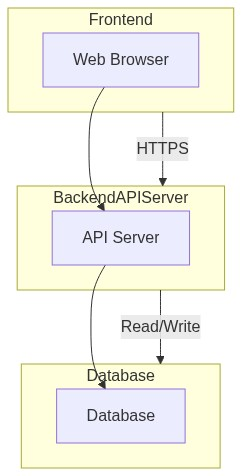

In [33]:
 # Render the diagram
if component_mermaid:
    render_mermaid_diagram(component_mermaid, "Capstone/capstone_artifacts\\affirmation.png")

In [35]:
architecture_document_prompt = f"""
You are an expert system architect.
Generate a high-level architecture document for an affirmation logging tool based on the following PRD.

**Context**
<prd>
{prd_content}
</prd>

<architecture diagram>
{component_mermaid}
</architecture diagram>

The document should include:
1. **Introduction**: A brief overview of the system's purpose.
2. **Architecture Diagram**: A description of the components and their interactions.
3. **Component Descriptions**: A detailed description of each component, including its responsibilities and interactions.
4. **Data Flow**: A description of how data flows through the system.

Output the document in markdown format, including the Mermaid diagram as an image link.
"""

architecture = get_completion(architecture_document_prompt, client, model_name, api_provider)
save_artifact(architecture, "Capstone/capstone_artifacts/architecture.md")

✅ Successfully saved artifact to: Capstone/capstone_artifacts/architecture.md


# Phase 3 - FastAPI Backend

- Generate Python code for a FastAPI backend using the SQL schema.
- Start with a basic in-memory database.
- Add SQLAlchemy models and database session management.
- Refactor code to use use FastAPI endpoints instead of local memory.

Notes: Good opportunity to use a more complex system such as RAG to automate all steps into a single process.

In [40]:
in_memory_api_prompt = f"""
You are a senior Python developer creating a FastAPI application for an affirmation logging tool.

Based on the following SQL schema, generate a single Python script for a `main.py` file that includes:
1.  All necessary FastAPI imports.
2.  Pydantic models for creating and reading `User` resources. Include fields for `id`, `name`.
3.  Pydantic models for creating and reading `Affirmation` resources. Include fields for `id`, `message`, `date`, `category`, and a foreign key to the user.
4.  A simple in-memory list to act as a fake database for users.
5.  Complete FastAPI CRUD endpoints for the `/users` and `/messages` paths (POST, GET all, GET by ID).
6.  The endpoints should perform their logic on the in-memory list.

**SQL Schema Context:**
```sql
{cleaned_schema}
```

Output only the raw Python code.
"""

print("--- Generating FastAPI app with in-memory database ---")
if cleaned_schema:
    generated_api_code = get_completion(in_memory_api_prompt, client, model_name, api_provider)
    cleaned_code = clean_llm_output(generated_api_code, language='python')
    # Save this code to a temporary reference file
    save_artifact(cleaned_code, "Capstone/main_in_memory.py")
    print("Saved in-memory API to main_in_memory.py")
else:
    print("Skipping API generation because schema is missing.")

--- Generating FastAPI app with in-memory database ---
✅ Successfully saved artifact to: Capstone/main_in_memory.py
Saved in-memory API to main_in_memory.py


In [36]:
db_code_prompt = f"""
You are a Python expert specializing in FastAPI and SQLAlchemy.

Based on the provided SQL schema, generate the necessary Python code to connect a FastAPI application to a SQLite database named 'affirmation.db'.

**SQL Schema Context:**
```sql
{cleaned_schema}
```

Please provide two separate, well-commented code blocks:

1.  **SQLAlchemy Models:** Create the Python classes that map to the `users` and `affirmation_messages` tables.
2.  **Database Session Management:** Provide the standard boilerplate code for creating the SQLAlchemy engine, the `SessionLocal` class, and the `get_db` dependency for FastAPI.

Only output the raw Python code.
"""

print("--- Generating SQLAlchemy Models and Session Code ---")
if cleaned_schema:
    generated_db_code = get_completion(db_code_prompt, client, model_name, api_provider)
    print("\n--- Generated Database Code ---")
    print(generated_db_code)
else:
    print("Skipping DB code generation because schema is missing.")

--- Generating SQLAlchemy Models and Session Code ---

--- Generated Database Code ---
```python
# SQLAlchemy Models

from sqlalchemy import Column, Integer, String, ForeignKey
from sqlalchemy.orm import relationship, declarative_base

# Base class for SQLAlchemy models
Base = declarative_base()

# User model representing the 'users' table
class User(Base):
    __tablename__ = 'users'
    
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String, nullable=False)

    # Relationship to access user's affirmation messages
    affirmations = relationship("AffirmationMessage", back_populates="user")

# AffirmationMessage model representing the 'affirmation_messages' table
class AffirmationMessage(Base):
    __tablename__ = 'affirmation_messages'
    
    id = Column(Integer, primary_key=True, autoincrement=True)
    user_id = Column(Integer, ForeignKey('users.id'), nullable=False)
    message = Column(String, nullable=False)
    category = Column(String)
    d

# Phase 4 - Testing & Security

- Use a simple LLM call to generate unit tests for our FastAPI backend.
- Tests should cover both happy-path and edge cases.
- Test by running pytest.
- Generate a security review by passing the LLM our Python code.

In [58]:
def generate_unit_tests(api_code: str, client, model_name: str, api_provider: str) -> str:
    # Generates pytest unit tests for the given API code.
    test_generation_prompt = f"""
You are a senior software engineer. Based on the following FastAPI application code, generate a comprehensive suite of unit tests using pytest.
The tests must cover both happy path and edge cases for all CRUD endpoints.
Use a mock database or in-memory database setup appropriate for testing.

**API Code Context:**
```python
{api_code}
```

Output only the raw Python code for the test file.
"""
    generated_tests = get_completion(test_generation_prompt, client, model_name, api_provider)
    return clean_llm_output(generated_tests, language='python')

# Load the FastAPI application code.
api_code_content = load_artifact("Capstone/main.py")

if api_code_content:
    print("--- Generating Unit Tests ---")
    # Generate the test suite.
    test_suite_code = generate_unit_tests(api_code_content, client, model_name, api_provider)
    print(test_suite_code)
    
    # Save the generated tests to a file.
    save_artifact(test_suite_code, "Capstone/tests/test_main.py")
else:
    print("Skipping test generation because main.py is missing.")

--- Generating Unit Tests ---
import pytest
from fastapi.testclient import TestClient
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.pool import StaticPool

# The API code is assumed to be in a file named `main.py` in the same directory.
# If your file is named differently, update the import statement accordingly.
from main import app, get_db, Base, User

# --- Test Database Setup ---
# Use an in-memory SQLite database for isolated testing
SQLALCHEMY_DATABASE_URL = "sqlite:///:memory:"

engine = create_engine(
    SQLALCHEMY_DATABASE_URL,
    connect_args={"check_same_thread": False},
    poolclass=StaticPool,  # Recommended for SQLite in-memory with TestClient
)
TestingSessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)


# --- Dependency Override ---
# This function will override the `get_db` dependency in the main application
# to use our in-memory test database instead of the production one.
def override_get_db()

In [62]:
def review_code_security(code: str, client, model_name: str, api_provider: str) -> str:
    # Prompts an LLM to review Python code for security vulnerabilities.
    review_prompt = f"""
Act as security expert with a specializtion in Python. Analyze the following Python code for security vulnerabilities.
Provide a detailed security review in Markdown format. For each finding, include a title, severity (Critical, High, Medium, Low), a description of the vulnerability, and a recommendation for fixing it.

**Python Code to Review:**
```python
{code}
```

Output only the raw Markdown report. Do not use any fences or code blocks, such as markdown, python, json, in the output. 
"""
    security_report = get_completion(review_prompt, client, model_name, api_provider)
    return clean_llm_output(security_report, language='markdown')

# Load the FastAPI application code.
api_code_content = load_artifact("Capstone/main.py")

if api_code_content:
    print("--- Performing Security Review ---")
    # Generate the security review.
    review_markdown = review_code_security(api_code_content, client, model_name, api_provider)
    print(review_markdown)
    
    # Save the generated review to a file.
    save_artifact(review_markdown, "Capstone/capstone_artifacts/security_review.md")
else:
    print("Skipping security review because main.py is missing.")

--- Performing Security Review ---
# Security Review of Affirmation API

This report details the security vulnerabilities found in the provided Python FastAPI application code. The analysis was conducted from the perspective of a security expert specializing in Python. The findings are listed in descending order of severity.

---

### **Finding 1: Critical: Missing Authentication and Authorization Controls**

**Severity:** Critical

**Description:**
The API has no authentication or authorization mechanisms. Any user on the internet can access all endpoints, including those that create and retrieve data. There is no concept of user identity, sessions, or ownership. This allows any anonymous user to view all data for all users, create new users, and create affirmation messages on behalf of any existing user. This fundamentally breaks the principles of confidentiality and integrity.

For example, an attacker can:
1.  Call `GET /users` to retrieve a list of all user IDs and names.
2.  Choo

# Phase 5 - React Front End

### Create a React front end for our application using a vision-enabled LLM.

Used langgraph to create a RAG chain that automates multiple steps in the code generation process.
1.  Create monolithic UI component
2.  Refactor into smaller, reusable components
3.  Validate the UI against the original image
4.  Rewrite the prompt and generate new code if required
5.  Save final code output to Artifacts

Notes: This task gave us a lot of trouble when trying to get the styling and formatting correct. A lot of time and effort was spent troubleshooting the generation of our front-end code.

In [ ]:
from IPython.display import Image, display, Code
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END

# Defines the state for the graph.
class GraphState(TypedDict):
    initial_prompt: str
    image_url: str
    generated_code: str
    refactored_code: str
    validation_result: str
    rewrite_attempts: int

# Node to generate the initial UI code from an image.
def generate_ui_from_image(state: GraphState) -> GraphState:
    print("--- Node: Generating Monolithic UI Component ---")
    prompt = state['initial_prompt']
    image_url = state['image_url']
    
    code = get_vision_completion(prompt, image_url, client, model_name, api_provider)
    cleaned_code = clean_llm_output(code, language='jsx')
    
    return {"generated_code": cleaned_code}

# Node to refactor the generated UI code.
def refactor_ui_code(state: GraphState) -> GraphState:
    print("\n--- Node: Refactoring UI into Smaller Components ---")
    code_to_refactor = state['generated_code']
    
    refactor_prompt = f"""
    You are a senior React developer with a focus on clean coding principles. Refactor the following monolithic component into smaller, reusable components.
    - Break the component into logical, self-contained pieces.
    - Output the complete, refactored code. Do not include any extra text.
    Code to refactor:
    ```jsx
    {code_to_refactor}
    ```
    """
    refactored_code = get_completion(refactor_prompt, client, model_name, api_provider)
    cleaned_refactored_code = clean_llm_output(refactored_code, language='jsx')
    
    return {"refactored_code": cleaned_refactored_code}

# Node to validate the UI against the original image.
def validate_ui_with_vision(state: GraphState) -> GraphState:
    print("\n--- Node: Validating UI against Image ---")
    code_to_validate = state['refactored_code']
    image_url = state['image_url']
    
    validation_prompt = f"""
    As a UI/UX expert, analyze the provided React code and image.
    Does the code's rendered output visually match the image's styling and format?
    Respond with only "yes" or "no".
    **React Code:**
    ```jsx
    {code_to_validate}
    ```
    """
    response = get_vision_completion(validation_prompt, image_url, client, model_name, api_provider)
    return {"validation_result": response.lower().strip()}

# Node to rewrite the initial prompt for better results.
def rewrite_ui_prompt(state: GraphState) -> GraphState:
    print("\n--- Node: Rewriting UI Generation Prompt ---")
    original_prompt = state['initial_prompt']
    
    meta_prompt = f"""
    You are a prompt engineering expert. Rewrite the following prompt to be more effective for a vision-enabled LLM generating React/JSX code from an image.
    **Original Prompt:**
    ```
    {original_prompt}
    ```
    **Instructions for Rewrite:**
    - Be more specific and demanding.
    - Emphasize pixel-perfect replication.
    - Explicitly list details to match: colors, fonts (size, weight), spacing, padding, border-radius, shadows.
    - The output should be ONLY the rewritten prompt text.
    """
    rewritten_prompt = get_completion(meta_prompt, client, model_name, api_provider)
    
    return {
        "initial_prompt": clean_llm_output(rewritten_prompt),
        "rewrite_attempts": state['rewrite_attempts'] + 1
    }

# Conditional edge to decide the next step after validation.
def decide_next_step(state: GraphState) -> str:
    print("\n--- Conditional Edge: Deciding Next Step ---")
    if state['validation_result'] == "yes" or state['rewrite_attempts'] >= 2:
        print("Decision: Validation passed or max retries reached. Ending.")
        return "end"
    else:
        print("Decision: Validation failed. Rewriting prompt.")
        return "rewrite"

# Build and compile the graph.
workflow = StateGraph(GraphState)
workflow.add_node("generate", generate_ui_from_image)
workflow.add_node("refactor", refactor_ui_code)
workflow.add_node("validate", validate_ui_with_vision)
workflow.add_node("rewrite", rewrite_ui_prompt)

workflow.set_entry_point("generate")
workflow.add_edge("generate", "refactor")
workflow.add_edge("refactor", "validate")
workflow.add_conditional_edges(
    "validate",
    decide_next_step,
    {"rewrite": "rewrite", "end": END}
)
workflow.add_edge("rewrite", "generate")

app = workflow.compile()

# Define initial state and run the graph.
ui_image_url = "https://i.ibb.co/7xvYDtHs/Affirmation-GUI-2.png"
initial_prompt = """
You are an expert UI/UX designer and React developer. Analyze the image at the following url {ui_image} and do the following:
1. Generate a single React component that implements the UI shown in the image.
2. Use material ui components and inline styling to match the design.
3. Ensure the component is self-contained and when rendered, it should look identical to the image.

It is very important that the generated code looks identical to the image. Match the styling, layout, and functionality as closely as possible.
Use the following guidelines:
- A light purple background and darker purple buttons matching the image.
- An elevated card for the tool containing Affirmation message input and category dropdown with submit button.
- Below the card, display another card with title of `Past Affirmations` and a list of past affirmations. Each list item should
be its own separate component containing a border, with the affirmation message text in black and the category in light grey, matching the image.
- The cards and the content of the cards should be centered in the middle of the page.
"""

initial_state = {
    "initial_prompt": initial_prompt,
    "image_url": ui_image_url,
    "rewrite_attempts": 0,
}

final_state = app.invoke(initial_state)

# Display the final generated code.
print("\n--- Final Result ---")
final_code = final_state.get("refactored_code", "No code generated.")
display(Code(final_code, language='jsx'))
save_artifact(final_code, "Capstone/src/App.jsx")

--- Node: Generating Monolithic UI Component ---

--- Node: Refactoring UI into Smaller Components ---

--- Node: Validating UI against Image ---

--- Conditional Edge: Deciding Next Step ---
Decision: Validation failed. Rewriting prompt.

--- Node: Rewriting UI Generation Prompt ---
--- Node: Generating Monolithic UI Component ---

--- Node: Refactoring UI into Smaller Components ---

--- Node: Validating UI against Image ---

--- Conditional Edge: Deciding Next Step ---
Decision: Validation failed. Rewriting prompt.

--- Node: Rewriting UI Generation Prompt ---
--- Node: Generating Monolithic UI Component ---

--- Node: Refactoring UI into Smaller Components ---

--- Node: Validating UI against Image ---

--- Conditional Edge: Deciding Next Step ---
Decision: Validation passed or max retries reached. Ending.

--- Final Result ---


import React, { useState, useEffect } from 'react';

// API URL
const API_URL = 'https://api.example.com/data';

// Loader Component
const Loader = () => <div>Loading...</div>;

// Error Component
const Error = ({ message }) => <div style={{ color: 'red' }}>{message}</div>;

// Data Item Component
const DataItem = ({ item }) => (
  <div>
    <h2>{item.title}</h2>
    <p>{item.description}</p>
  </div>
);

// Data List Component
const DataList = ({ data }) => (
  <div>
    {data.map(item => (
      <DataItem key={item.id} item={item} />
    ))}
  </div>
);

// Main Component
const MainComponent = () => {
  const [data, setData] = useState([]);
  const [loading, setLoading] = useState(true);
  const [error, setError] = useState(null);

  useEffect(() => {
    fetch(API_URL)
      .then(response => {
        if (!response.ok) {
          throw new Error('Network response was not ok');
        }
        return response.json();
      })
      .then(data => {
        setData(data);
        setLoading(false);
      })
      .catch(error => {
        setError(error.message);
        setLoading(false);
      });
  }, []);

  if (loading) return <Loader />;
  if (error) return <Error message={error} />;

  return <DataList data={data} />;
};

export default MainComponent;

✅ Successfully saved artifact to: Capstone/src/my-app/src/App.jsx


# Final Thoughts

- Getting the front end design correct was challenging. There are a lot of ways to save time using AI, but everything doesn't just magically get created for you and work right away. We had to spend a lot of time troubleshooting and refining our prompt to get a UI that matched our example image.
- AI has allowed us to speed up the requirements gathering process and quickly generate product documentation.
- The benefit of quick artifact creation through the use of AI compunds on itself by feeding those products back into future prompts.